In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train_data = pd.read_csv('../input/train.csv')
print(train_data.shape)
train_data.head()

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [3]:
train_text = train_data['question_text'].values
train_text

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       ..., 'Is foam insulation toxic?',
       'How can one start a research project based on biochemistry at UG level?',
       'Who wins in a battle between a Wolverine and a Puma?'],
      dtype=object)

In [4]:
import nltk

t_data = list()

for i in range(len(train_text)):
    
    if i % 100000 == 0:
        print(i)

    words = nltk.word_tokenize(train_text[i])

    words=[word.lower() for word in words if word.isalpha()]
    
    # remove single character

    words = [word for word in words if len(word) > 1]
    
    t_data.append(words)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000


In [5]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

data_l = list()
for i in range(len(t_data)):
    temp = list()
    for j in t_data[i]:
        temp.append(lemmatizer.lemmatize(j))
    data_l.append(temp)

In [6]:
vocab = list()

for i in data_l:
    for j in i:
        vocab.append(j)
# no of words in text
len(vocab)

15636924

In [7]:
# no of unique words

vocab = set(vocab)
len(vocab)

162577

In [15]:
from keras.preprocessing.text import Tokenizer
# function to build a tokenizer

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

eng_tokens = tokenization(data_l)
eng_vocab_size = len(eng_tokens.word_index) + 1
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 162578


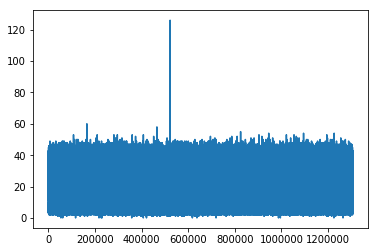

In [9]:
m = list()
for i in range(len(data_l)):
    m.append(len(data_l[i]))
plt.plot(m)

In [10]:
from keras.preprocessing.sequence import pad_sequences
# encode and pad sequences
def encode_sequences(tokenizer,length,lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

seq_data = encode_sequences(eng_tokens,60,data_l)

In [11]:
EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

print('Found %s word vectors.' % len(embeddings_index))

Found 2196016 word vectors.


In [19]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = eng_tokens.word_index
nb_words = min(eng_vocab_size - 1, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= eng_vocab_size - 1: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical

target = train_data['target'].values
target = to_categorical(target)

In [24]:
model = Sequential()
model.add(Embedding(eng_vocab_size - 1,
                    embed_size,
                    weights=[embedding_matrix],
                    input_length=60,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 300)           48773100  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 60, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 128)           187392    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41472     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 49,002,094
Trainable params: 228,994
Non-trainable params: 48,773,100
__________________________________________________________

In [25]:
batch_size = 128
history = model.fit(seq_data, target, epochs=5, batch_size=batch_size, verbose=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 1175509 samples, validate on 130613 samples
Epoch 1/5
1175509/1175509 [==============================] - 157s 134us/step - loss: 0.1185 - acc: 0.9537 - val_loss: 0.1068 - val_acc: 0.9577
Epoch 2/5
1175509/1175509 [==============================] - 155s 132us/step - loss: 0.1054 - acc: 0.9586 - val_loss: 0.1027 - val_acc: 0.9588
Epoch 3/5
1175509/1175509 [==============================] - 155s 132us/step - loss: 0.1002 - acc: 0.9604 - val_loss: 0.1006 - val_acc: 0.9594
Epoch 4/5
1175509/1175509 [==============================] - 156s 132us/step - loss: 0.0965 - acc: 0.9614 - val_loss: 0.1000 - val_acc: 0.9598
Epoch 5/5
1175509/1175509 [==============================] - 156s 133us/step - loss: 0.0935 - acc: 0.9626 - val_loss: 0.1001 - val_acc: 0.9601


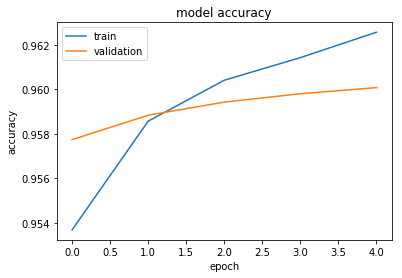

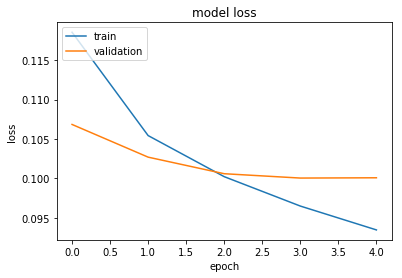

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
test_data = pd.read_csv('../input/test.csv')
print(test_data.shape)
test_data.head()

(375806, 2)


,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [28]:
sam_sub = pd.read_csv('../input/sample_submission.csv')
sam_sub.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [32]:
q_id = test_data['qid'].values
print(q_id.shape)

(375806,)


In [33]:
test_text = test_data['question_text'].values
print(test_text.shape)

(375806,)


In [34]:
t_data_test = list()

for i in range(len(test_text)):
    
    if i % 100000 == 0:
        print(i)

    words = nltk.word_tokenize(test_text[i])

    words=[word.lower() for word in words if word.isalpha()]
    
    # remove single character

    words = [word for word in words if len(word) > 1]
    
    t_data_test.append(words)

0
100000
200000
300000


In [35]:
data_l_test = list()
for i in range(len(t_data_test)):
    temp = list()
    for j in t_data_test[i]:
        temp.append(lemmatizer.lemmatize(j))
    data_l_test.append(temp)

In [36]:
seq_data_test = encode_sequences(eng_tokens,60,data_l_test)

In [38]:
pred = model.predict_classes(seq_data_test, verbose=1)

375806/375806 [==============================] - 54s 143us/step


In [39]:
pred.shape

(375806,)

In [42]:
q_id = q_id.reshape(-1,1)
print(q_id.shape)
pred = pred.reshape(-1,1)
print(pred.shape)

(375806, 1)
(375806, 1)


In [43]:
output = np.array(np.concatenate((q_id, pred), 1))

output = pd.DataFrame(output,columns = ["qid","prediction"])

output.to_csv('submission.csv',index = False)